Predicts the volume of bikes needed on various days in May 2021. Uses this dataset: https://www.kaggle.com/datasets/farjadanalytica/divvytripdata-1?select=202105-divvy-tripdata.csv 

In [38]:
# if using Google Colab
"""
from pathlib import Path
import shutil
if Path('Data').is_dir():
  shutil.rmtree('Data')
"""

"\nfrom pathlib import Path\nimport shutil\nif Path('Data').is_dir():\n  shutil.rmtree('Data')\n"

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
import urllib.request
import csv
import codecs
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# !unzip 'Data.zip' # if using Google Colab

In [40]:
months = ['202005', '202006', '202007', '202008', '202009', '202010', '202011', '202012', '202101', '202102', '202103', '202104', '202105']
ride_data_files = ['Data/' + month + '-divvy-tripdata.csv' for month in months]
df_divvy = pd.concat((pd.read_csv(f) for f in ride_data_files))
print(len(df_divvy))

3391402


In [41]:
# Get historical weather data
weather_df = pd.read_csv('Data/chicago_daily_weather_data.csv')
weather_df.loc[weather_df['datetime'] == '2020-05-01']

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"chicago, illinois",2020-05-01,66.6,38.6,53.6,66.6,38.6,53.4,35.6,54.7,...,22.7,9,NaN,2020-05-01T05:46:00,2020-05-01T19:49:49,0.28,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72534014819,KORD,KMDW,72530094846,74466504838,..."


In [42]:
# Merge weather data and Divvy dataset
df_divvy['datetime'] = df_divvy.apply(lambda x : x['started_at'].split(' ')[0], axis=1)
df_divvy['datetime'] = df_divvy['datetime'].apply(lambda x : x.split('/')[2] + '-' + ('0' + x.split('/')[0])[-2:] + '-' + ('0' + x.split('/')[1])[-2:])
print(df_divvy.head())
df_divvy_weather = pd.merge(df_divvy, weather_df, on='datetime', how='left')
df_divvy_weather[['started_at', 'datetime', 'temp', 'precip', 'windspeed']].iloc[[1,3000,5000,7000,10000,15000,20000]]
print(len(df_divvy))
print(len(df_divvy_weather))

            ride_id rideable_type       started_at         ended_at  \
0  93708F49670AE324   docked_bike    5/7/2020 1:18   5/27/2020 2:55   
1  305C4EFEBE542DA7   docked_bike  5/15/2020 15:12  5/26/2020 16:40   
2  0C666D8148BD3A6F   docked_bike    5/1/2020 7:48   5/12/2020 7:49   
3  6BFE0820278C6D56   docked_bike  5/19/2020 12:29  5/29/2020 13:05   
4  4323B2931BF64CA3   docked_bike  5/13/2020 16:50  5/23/2020 17:12   

            start_station_name start_station_id            end_station_name  \
0  Spaulding Ave & Division St              510     Karlov Ave & Madison St   
1      MLK Jr Dr & Pershing Rd              179      St. Clair St & Erie St   
2               DuSable Museum              422    Commercial Ave & 83rd St   
3      Lincoln Ave & Winona St              472     Lincoln Ave & Winona St   
4     Southport Ave & Clark St              292  Clarendon Ave & Leland Ave   

  end_station_id  start_lat  start_lng  end_lat  end_lng member_casual  \
0            534    41.9

In [43]:
# Used to find features that are most highly correlated with number of rides
# Input: ride and weather data. Output: features for which p value for chi2 is less than 0.05
def chi2_test(df):
  ridership_cutoff = 1000 # less than this is fewer rides, more than this is more rides
  features_cutoffs = {'weekend_or_holiday': '>0.01', 'temp': '>50', 'precip': '<0.01', 'windspeed': '<20', 'snowdepth': '<0.01', 'humidity': '<65', 'feelslike': '>50'} # key: feature, value: rule for distinguishing good weather from bad weather for that feature
  influential_features = {} # key: feature, value: p value. Only includes features with p value less than 0.05
  ridershiphigh_weathergood, ridershiphigh_weatherbad, ridershiplow_weathergood, ridershiplow_weatherbad = None, None, None, None

  for feature in list(features_cutoffs.keys()):
    feature_cutoff = float(features_cutoffs[feature][1:])
    if features_cutoffs[feature][0] == '>':
      ridershiphigh_weathergood = len(df[(df['rides_count']>=ridership_cutoff)&(df[feature]>=feature_cutoff)])
      ridershiphigh_weatherbad = len(df[(df['rides_count']>=ridership_cutoff)&(df[feature]<feature_cutoff)])
      ridershiplow_weathergood = len(df[(df['rides_count']<ridership_cutoff)&(df[feature]>=feature_cutoff)])
      ridershiplow_weatherbad = len(df[(df['rides_count']<ridership_cutoff)&(df[feature]<feature_cutoff)])
    elif features_cutoffs[feature][0] == '<':
      ridershiphigh_weathergood = len(df[(df['rides_count']>=ridership_cutoff)&(df[feature]<=feature_cutoff)])
      ridershiphigh_weatherbad = len(df[(df['rides_count']>=ridership_cutoff)&(df[feature]>feature_cutoff)])
      ridershiplow_weathergood = len(df[(df['rides_count']<ridership_cutoff)&(df[feature]<=feature_cutoff)])
      ridershiplow_weatherbad = len(df[(df['rides_count']<ridership_cutoff)&(df[feature]>feature_cutoff)])
    table = [[ridershiphigh_weathergood, ridershiphigh_weatherbad],[ridershiplow_weathergood, ridershiplow_weatherbad]]
    p = stats.chi2_contingency(table)[1]
    if p < 0.05:
      influential_features[feature] = p
  
  return influential_features
    

In [44]:
# Find total number of bikes used on each day
ride_date_counts = {} # key: ride_date, value: number of rides on that date
ride_date_weather = {} # key: ride_date, value: [temp, precip, windspeed, snowdepth, humidity, feelslike]
ride_date_weekend_bool = {} # key: ride_date, value: 1 if the date is a Saturday, Sunday, or holiday, else 0
holidays = ['2020-01-01', '2020-01-20', '2020-05-25', '2020-07-03', '2020-09-07', '2020-11-11', '2020-11-26', '2020-12-25',
            '2021-01-01', '2020-01-18', '2021-05-31', '2021-07-05', '2021-09-06', '2021-11-11', '2021-11-25', '2021-12-24', '2021-12-31']
for index, row in df_divvy_weather.iterrows():
    if row['datetime'] not in ride_date_counts.keys():
      ride_date_counts[row['datetime']] = 1
      ride_date_weather[row['datetime']] = [row['temp'], row['precip'], row['windspeed'], row['snowdepth'], row['humidity'], row['feelslike']]
      current_timestamp = pd.Timestamp(row['datetime'])
      ride_date_weekend_bool[row['datetime']] = int(current_timestamp.dayofweek in [5,6] or row['datetime'] in holidays)
    else:
      ride_date_counts[row['datetime']] += 1


ride_data = pd.DataFrame()
ride_data['datetime'] = list(ride_date_counts.keys())
ride_data['rides_count'] = list(ride_date_counts.values())
ride_data['weekend_or_holiday'] = list(ride_date_weekend_bool.values())
ride_data['temp'] = [weather_data[0] for weather_data in list(ride_date_weather.values())]
ride_data['precip'] = [weather_data[1] for weather_data in list(ride_date_weather.values())]
ride_data['windspeed'] = [weather_data[2] for weather_data in list(ride_date_weather.values())]
ride_data['snowdepth'] = [weather_data[3] for weather_data in list(ride_date_weather.values())]
ride_data['humidity'] = [weather_data[4] for weather_data in list(ride_date_weather.values())]
ride_data['feelslike'] = [weather_data[5] for weather_data in list(ride_date_weather.values())]

# Do chi2 test to determine which variables most influence Divvy bike usage
significant_features = chi2_test(ride_data)
print(significant_features)

x = ride_data[['weekend_or_holiday', 'feelslike', 'humidity']] # Use features that the chi2 test showed were most important
y = ride_data[['rides_count']]

{'weekend_or_holiday': 0.015342872964248926, 'temp': 0.0008313071172927805, 'snowdepth': 3.268898539634542e-08, 'humidity': 0.011051053125211851, 'feelslike': 0.0015760777242487035}


In [45]:
# Feature transformation

# PCA: no longer used
"""
pca = PCA(n_components=1)
x = pca.fit_transform(x)
"""
# Scaling
scaling_type = 'standard'
if scaling_type == 'standard':
  scaler = StandardScaler()
elif scaling_type == 'minmax':
  scaler = MinMaxScaler()
x = scaler.fit_transform(x)
print(x)

[[-0.66972338  0.11881302 -1.25076601]
 [-0.66972338  0.69905906  1.2543753 ]
 [-0.66972338  0.11881302 -0.63894932]
 ...
 [-0.66972338  0.68160805  0.75003992]
 [-0.66972338 -0.00334404 -1.78817257]
 [ 1.49315378  0.32822512 -0.80430518]]


In [46]:
# Train and test linear regression model
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
coef = linear_model.coef_
intercept = linear_model.intercept_
print(linear_model.score(X_test, y_test)) # R^2
print(coef)
print(intercept)
print(len(x))

0.5477511849017459
[[ 1266.45487247  4689.49466841 -1174.69183663]]
[8679.33243279]
394


In [47]:
# Polynomial fit
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X_train) 
print(X_train[0:4])
print(poly_features[0:4])
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y_train)
coef = poly_reg_model.coef_
intercept = poly_reg_model.intercept_
X_test_features = poly.fit_transform(X_test)
print(poly_reg_model.score(X_test_features, y_test)) # R^2
print(coef)
print(intercept)



[[-0.66972338 -0.3349132   0.27050792]
 [ 1.49315378  0.95646143 -0.20902408]
 [ 1.49315378 -1.02859079  1.68430055]
 [-0.66972338  0.24533283 -1.8708505 ]]
[[-0.66972338 -0.3349132   0.27050792  0.44852941  0.2242992  -0.18116548
   0.11216685 -0.09059667  0.07317454]
 [ 1.49315378  0.95646143 -0.20902408  2.2295082   1.428144   -0.31210509
   0.91481847 -0.19992347  0.04369107]
 [ 1.49315378 -1.02859079  1.68430055  2.2295082  -1.53584423  2.51491972
   1.05799902 -1.73245603  2.83686833]
 [-0.66972338  0.24533283 -1.8708505   0.44852941 -0.16430514  1.25295233
   0.0601882  -0.45898105  3.50008158]]
0.6278683848585258
[[-3.15001071e+15  5.19300000e+03 -1.18475000e+03  3.82547298e+15
   9.64437500e+02 -3.53500000e+02  9.99156250e+02 -8.20210938e+02
  -4.51937500e+02]]
[-3.82547298e+15]


In [48]:
# Ridge and Lasso Regression
from sklearn.linear_model import Ridge, Lasso

def regression_optimizer(model, parameters, X_train, y_train, X_test, y_test):
  clf = GridSearchCV(model, parameters,cv=5)
  clf.fit(X_train,y_train)
  mean_test_score = clf.cv_results_['mean_test_score']
  print(mean_test_score)
  best_params = clf.best_params_
  best_score = clf.best_score_
  # Find performance and coefficients for best model
  clf = Ridge(alpha=clf.best_params_['alpha'])
  clf.fit(X_train, y_train)
  clf.predict(X_test)
  test_score = clf.score(X_test, y_test)
  coef = clf.coef_
  intercept = clf.intercept_
  print(best_params)
  print(best_score)
  print(test_score)
  print(coef)
  print(intercept)
  return best_params, best_score, test_score, mean_test_score, coef, intercept
   

print("Linear, Ridge")
#parameters = {'alpha':[0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.2, 0.3, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 2.6, 2.7, 2.8, 2.9, 3, 3.05, 3.1, 3.15, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4, 5.0, 6, 7, 8, 9, 10]}
lr_parameters = {'alpha':[0.1, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 3, 3.2, 3.41, 3.42, 3.43, 3.44, 3.45, 3.46, 3.57, 3.48, 3.49, 3.5, 3.51, 3.52, 3.53, 3.54, 3.55, 3.56, 3.57, 3.58, 3.59, 5, 10, 15, 100, 500, 1000]}
lr_best_params, lr_best_score, lr_test_score, lr_mean_test_score, lr_coef, lr_intercept = regression_optimizer(Ridge(), lr_parameters, X_train, y_train, X_test, y_test)

print("Polynomial, Ridge")
#parameters = {'alpha': [50.0, 100, 200, 300, 400, 450, 460, 470, 480, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 499.5, 499.8, 499.9, 499.95, 500, 500.05, 500.1, 500.2, 500.5, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 600, 800, 900, 1000, 1500, 2000, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3650, 3700, 3730, 3740, 3750, 3760, 3770, 3800]}
#parameters = {'alpha': [10,11,12,13,14,15,16,17,18,19,20,21,21.5,21.6,21.7,21.75,21.76,21.77,21.78,21.79,21.8,21.81,21.82,21.83,21.84,21.85,21.9,22,22.1,22.2,22.3,22.4,22.5,22.6,22.7,22.8,22.9,23,24,25,26,27,28,29]}
#pr_parameters = {'alpha': [0.1, 1, 3, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5, 6, 7, 8, 9, 10, 19.1, 19.5, 19.7, 19.8, 19.9, 20, 20.1, 20.15, 20.2, 20.21, 20.22, 20.23, 20.24, 20.25, 20.26, 20.27, 20.28, 20.29, 20.3, 20.4, 20.5, 20.7, 21, 50, 100, 500, 1000]}
pr_parameters = {'alpha': [i*4.1 for i in range(0,50)]}
pr_best_params, pr_best_score, pr_test_score, pr_mean_test_score, pr_coef, lr_intercept = regression_optimizer(Ridge(), pr_parameters, poly_features, y_train, X_test_features, y_test)

print("Linear, Lasso")
#parameters = {'alpha':[0, 0.00001, 0.0001, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.03, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 1.0, 1.05, 1.1, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.3, 1.35, 1.38, 1.4, 1.41, 1.42, 1.43, 1.44, 1.45, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 16.1, 16.2, 16.3, 16.4, 16.5, 16.6, 16.7, 16.8, 16.9, 17, 17.1, 17.2, 17.3, 17.4, 17.5, 17.6, 17.7, 17.8, 17.9, 18, 19, 20, 25, 30, 35, 40, 45, 50, 100, 500, 1000]}
ll_parameters = {'alpha':[i*8.4 for i in range(0,25)]}
ll_best_params, ll_best_score, ll_test_score, ll_mean_test_score, ll_coef, lr_intercept = regression_optimizer(Lasso(), ll_parameters, X_train, y_train, X_test, y_test)

print("Polynomial, Lasso")
#parameters = {'alpha':[10, 50, 60, 70, 80, 90, 100, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 120, 130, 140, 150, 200]}
pl_parameters = {'alpha':[0.1, 0.5, 0.6, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.8, 0.9, 1, 1.5, 2, 3, 3.5, 3.51, 3.52, 3.53, 3.54, 3.55, 3.56, 3.57, 3.58, 3.59, 3.6, 3.61, 3.62, 3.63, 3.64, 3.65, 3.66, 3.67, 3.68, 3.69, 3.7, 3.8, 3.9, 4, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7,8,9,9.5, 9.6, 9.7, 9.8, 9.9, 10, 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11,11.5,12,12.1,12.2,12.3,12.4,12.5,12.55,12.56,12.57,12.58,12.59,12.6,12.61,12.62,12.63,12.64,12.65,12.7,12.8,12.9,13,14, 50, 100, 500, 1000]}
pl_best_params, pl_best_score, pl_test_score, pl_mean_test_score, pl_coef, lr_intercept = regression_optimizer(Lasso(), pl_parameters, poly_features, y_train, X_test_features, y_test)



Linear, Ridge
[0.58077029 0.58078128 0.5807836  0.58078574 0.58078771 0.5807895
 0.58079112 0.58079667 0.58079727 0.5807977  0.58079796 0.58079805
 0.58079798 0.58079773 0.58079732 0.58079674 0.580796   0.58079509
 0.58079401 0.58078805 0.58078409 0.58077923 0.58077898 0.58077873
 0.58077848 0.58077822 0.58077797 0.58077504 0.58077745 0.58077719
 0.58077693 0.58077666 0.5807764  0.58077613 0.58077586 0.58077559
 0.58077532 0.58077504 0.58077477 0.58077449 0.58071944 0.5802806
 0.57949396 0.5383886  0.33420999 0.21828333]
{'alpha': 1.9}
0.5807980525257721
0.5482511088192509
[[ 1259.6667396   4661.09785883 -1172.23897958]]
[8678.90374458]
Polynomial, Ridge


C:\Users\there\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.26817e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


[0.64296687 0.64333492 0.64309759 0.64243503 0.64140342 0.64005124
 0.63842039 0.63654727 0.63446353 0.63219679 0.62977124 0.62720805
 0.62452584 0.62174102 0.61886803 0.61591965 0.61290719 0.60984066
 0.60672895 0.60357996 0.60040071 0.59719744 0.59397572 0.59074051
 0.58749624 0.58424684 0.58099584 0.57774637 0.57450124 0.57126294
 0.5680337  0.56481549 0.56161009 0.55841906 0.55524379 0.55208551
 0.54894532 0.54582417 0.5427229  0.53964226 0.53658288 0.53354533
 0.53053009 0.52753756 0.52456809 0.52162198 0.51869945 0.5158007
 0.51292587 0.51007508]
{'alpha': 4.1}
0.6433349181443198
0.6296593194401521
[[  794.76632205  5106.28768053 -1179.57817712   654.43474315
    951.78921326  -349.08568294   962.25620219  -786.42458771
   -454.63773304]]
[7415.51573209]
Linear, Lasso


C:\Users\there\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\there\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\there\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2169484268.8314476, tolerance: 1152913.5482079368
  model = cd_fast.enet_coordinate_descent(
C:\Users\there\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimato

[0.5807671  0.58078088 0.58078541 0.58078061 0.58076694 0.58074417
 0.5807123  0.58067133 0.58062125 0.58056207 0.58049379 0.58041641
 0.58032992 0.58023433 0.58012964 0.58001585 0.57989295 0.57976096
 0.57961989 0.57946969 0.57931038 0.57914198 0.57896447 0.57877786
 0.57858214]
{'alpha': 16.8}
0.5807854117907905
0.5506190956519172
[[ 1208.68295496  4450.12891929 -1152.14809516]]
[8675.6912962]
Polynomial, Lasso


C:\Users\there\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59770002.88424158, tolerance: 1102084.1435186511
  model = cd_fast.enet_coordinate_descent(
C:\Users\there\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59954692.196926594, tolerance: 1102084.1435186511
  model = cd_fast.enet_coordinate_descent(


[0.64308196 0.64308302 0.64308327 0.64308339 0.64308343 0.64308345
 0.6430835  0.64308351 0.64308353 0.64308355 0.64308359 0.64308362
 0.64308364 0.64308367 0.64308381 0.64308404 0.64308429 0.64308548
 0.64308655 0.64308834 0.64308901 0.64308901 0.64308905 0.64308905
 0.64308909 0.64308909 0.64308913 0.64308912 0.64308916 0.64308911
 0.64308915 0.64308918 0.64308919 0.64308922 0.64308908 0.64308912
 0.64308911 0.64308915 0.64308915 0.64308918 0.64308921 0.64308937
 0.6430894  0.64308959 0.64308969 0.64308971 0.64308983 0.64308998
 0.64309012 0.6430901  0.64309023 0.64309029 0.64309043 0.64309032
 0.64309044 0.64309055 0.64309064 0.64309073 0.64309061 0.64309067
 0.64309075 0.64309082 0.64309085 0.64309091 0.64309071 0.64309077
 0.64309081 0.64309084 0.64309087 0.64309091 0.64309093 0.64309092
 0.64309068 0.64309069 0.64309037 0.64308952 0.64308889 0.64308875
 0.64308833 0.64308822 0.64308808 0.64308793 0.64308778 0.64308758
 0.64308744 0.64308726 0.64308709 0.64308691 0.64308674 0.6430

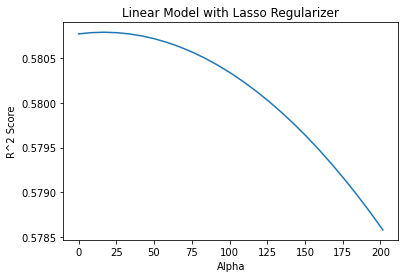

In [49]:
# Graph alpha and R^2 score for best linear model (Lasso regularization)
plt.plot(ll_parameters['alpha'], ll_mean_test_score)
plt.xlabel('Alpha')
plt.ylabel('R^2 Score')
plt.title('Linear Model with Lasso Regularizer')
plt.savefig('Linear_Lasso.png')

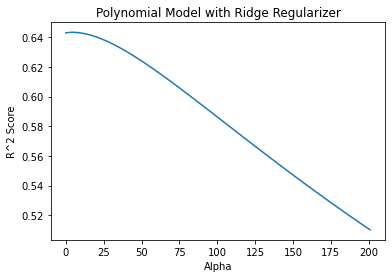

In [50]:
# Graph alpha and R^2 score for best polynomial model (Ridge regularization)
plt.plot(pr_parameters['alpha'], pr_mean_test_score)
plt.xlabel('Alpha')
plt.ylabel('R^2 Score')
plt.title('Polynomial Model with Ridge Regularizer')
plt.savefig('Polynomial_Ridge.png')